In [2]:
# 每个国家的所有城市的确诊数据作为该国家的单变量预测，即该变量有多个time series
# 全球的所有国家的确诊数据作为全球的单变量预测，即该变量有多个time series

import pandas as pd
import numpy as np

from gluonts.dataset.common import ListDataset
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.field_names import FieldName

import matplotlib.pyplot as plt
plt.style.use('seaborn')

## Define customer dataset

In [3]:
data=pd.read_csv('data/demo.csv',index_col=0)
data.index=pd.DatetimeIndex(data.index)
data.head()

,Anhui,Beijing,Chongqing,Fujian,Gansu,Guangdong,Guangxi,Guizhou,Hainan,Hebei,...,Shandong,Shanghai,Shanxi,Sichuan,Tianjin,Tibet,Unknown,Xinjiang,Yunnan,Zhejiang
2020-01-22,1,14,6,1,0,26,2,1,4,1,...,2,9,1,5,4,0,0,0,1,10
2020-01-23,9,22,9,5,2,32,5,3,5,1,...,6,16,1,8,4,0,0,2,2,27
2020-01-24,15,36,27,10,2,53,23,3,8,2,...,15,20,1,15,8,0,0,2,5,43
2020-01-25,39,41,57,18,4,78,23,4,19,8,...,27,33,6,28,10,0,0,3,11,62
2020-01-26,60,68,75,35,7,111,36,5,22,13,...,46,40,9,44,14,0,0,4,16,104


In [4]:
# target_series=np.random.randn(100,24*7)
# start_series=[pd.Period('01-01-2019',freq=freq) for _ in range(100)]
# freq='1H'

target_col_names=['Anhui']
# target_col_names=['Anhui']
target_series=data[target_col_names].to_numpy().T #shape=[num_series,num_steps],Convention: time axis is always the last axis.
start_series=data.index

freq='1D'
prediction_length=24
context_length=2*prediction_length
num_dynamic_real_features=0
num_static_categorical_features=0
num_static_real_features=0

In [5]:
train_ds=ListDataset(
    [
        {   
            FieldName.START:start_series[0],
            FieldName.TARGET:target
        }
        for target in target_series[:,:-prediction_length]
    ],
    freq=freq
)

test_ds=ListDataset(
    [
        {   
            FieldName.START:start_series[0],
            FieldName.TARGET:target
        }
        for target in target_series
    ],
    freq=freq
)

# assert len(train_ds)+prediction_length==len(test_ds)

In [6]:
train_ds

[{'start': Period('2020-01-22', 'D'),
  'target': array([1.000e+00, 9.000e+00, 1.500e+01, ..., 2.275e+03, 2.275e+03,
         2.275e+03], dtype=float32)}]

## Define the model

In [7]:
# time features
from gluonts.time_feature import time_features_from_frequency_str,get_lags_for_frequency,TimeFeature

# lag_seq=get_lags_for_frequency(freq)
lag_seq=[1,2,3]
time_features=time_features_from_frequency_str(freq)
print(lag_seq,time_features,sep='\n')

[1, 2, 3]
[<function day_of_week at 0x12a516550>, <function day_of_month at 0x12a516670>, <function day_of_year at 0x12a516790>]


In [8]:
from transformers import TimeSeriesTransformerConfig,TimeSeriesTransformerForPrediction

n_encoder_layers=4
n_decoder_layers=4
d_model=4

config=TimeSeriesTransformerConfig(
    # input_size=input_size,
    prediction_length=prediction_length,
    context_length=context_length,
    lags_sequence=lag_seq,
    num_time_features=len(time_features)+1,#time_features_from_frequency_str(freq)=3 and add another time feature called AgeFeature
    num_static_categorical_features=num_static_categorical_features,
    cardinality=[len(train_ds[0]['target'])],
    embedding_dimension=[2],

    encoder_layers=n_encoder_layers,
    decoder_layers=n_decoder_layers,
    d_model=d_model,
)

model=TimeSeriesTransformerForPrediction(config)
print(model.config.distribution_output)#time series transformer consists of a distribution head on top instead of nn.Linear in the NLP tasks.

student_t


## Define the transformation

In [9]:
from gluonts.time_feature import time_features_from_frequency_str,get_lags_for_frequency

from gluonts.transform import (
    AddAgeFeature,AddTimeFeatures,VstackFeatures,
    AddObservedValuesIndicator,
    Chain,
    RenameFields,RemoveFields,SelectFields
)

def createTransformation(freq,config):
    return Chain(
        [
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            # temporal features serve as positional encodings
            AddTimeFeatures(
                start_field=FieldName.START,
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_TIME,
                time_features=time_features_from_frequency_str(freq),# 返回len(time_features_from_frequency_str(freq))*len(train_ds)的array
                pred_length=config.prediction_length,
            ),
            # another temporal feature
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=config.prediction_length,
                log_scale=True,#age feature grows logarithmically otherwise linearly overtime.
            ),
            # vertically stack all the temporal features into FieldName.FEAT_TIME
            VstackFeatures(
                output_field=FieldName.FEAT_TIME,
                input_fields=[FieldName.FEAT_TIME,FieldName.FEAT_AGE],
                h_stack=False,#dim=0 if h_stack=False else dim=1
            ),
            # InstanceSplitter(
            #     target_field=FieldName.TARGET,
            #     is_pad_field=FieldName.IS_PAD,
            #     start_field=FieldName.START,
            #     forecast_start_field=FieldName.FORECAST_START,
            #     instance_sampler=ExpectedNumInstanceSampler(num_instances=1,min_future=prediction_length),
            #     past_length=context_length,
            #     future_length=prediction_length,
            #     time_series_fields=[FieldName.FEAT_AGE,FieldName.OBSERVED_VALUES]
            # )
            RenameFields(
                mapping={
                    FieldName.OBSERVED_VALUES:'observed_mask',
                    FieldName.FEAT_TIME:'time_features',
                    FieldName.TARGET:'values'
                }
            )
        ]
    )

transformation=createTransformation(freq,config)
train_tf=transformation.apply(train_ds,is_train=True)
test_tf=transformation.apply(test_ds,is_train=False)

## Define the InstanceSplitter

In [10]:
from gluonts.transform.sampler import ExpectedNumInstanceSampler,ValidationSplitSampler,TestSplitSampler
from gluonts.transform import InstanceSplitter

def createInstanceSplitter(config,mode,train_sampler=None,validation_sampler=None):
    assert mode in ['train','validation','test']

    instance_sampler={
        'train':train_sampler or ExpectedNumInstanceSampler(num_instances=1,min_future=prediction_length),
        'validation':validation_sampler or ValidationSplitSampler(min_future=prediction_length),
        'test':TestSplitSampler(),
    }[mode]

    return InstanceSplitter(
        target_field='values',
        is_pad_field=FieldName.IS_PAD,
        start_field=FieldName.START,
        forecast_start_field=FieldName.FORECAST_START,
        instance_sampler=instance_sampler,
        past_length=context_length+max(lag_seq),
        future_length=prediction_length,
        time_series_fields=['time_features','observed_mask']
    )

In [11]:
from gluonts.itertools import Cyclic, IterableSlice, PseudoShuffled
from gluonts.torch.util import IterableDataset
from torch.utils.data import DataLoader

def createTrainDataLoader(config,freq,data,batch_size,num_batches_per_epoch,shuffle_buffer_length=None):
    prediction_input_names=[
        'past_values',
        'past_time_features',
        'past_observed_mask',
        'future_time_features',
    ]
    if num_static_categorical_features>0:
        prediction_input_names.append('static_categorical_features')
    
    if num_static_real_features>0:
        prediction_input_names.append('static_real_features')

    training_input_names=prediction_input_names+[
        'future_values',
        'future_observed_mask',
    ]
    
    transformation=createTransformation(freq=freq,config=config)
    transformed_data=transformation.apply(data,is_train=True)
    
    instance_splitter=createInstanceSplitter(config,'train')+SelectFields(training_input_names)#在所选择的fields上create InstanceSplitter

    train_instances=instance_splitter.apply(
        Cyclic(transformed_data) if shuffle_buffer_length is None
        else PseudoShuffled(Cyclic(transformed_data),shuffle_buffer_length=shuffle_buffer_length)
    )

    return IterableSlice(
        iter(DataLoader(
            IterableDataset(train_instances),
            batch_size=batch_size,
        )),num_batches_per_epoch,#表示一次取num_batches_per_epoch个batches
    )

def createTestDataLoader(config,freq,data,batch_size):
    prediction_input_names=[
        'past_values',
        'past_time_features',
        'past_observed_mask',
        'future_time_features',
    ]
    if num_static_categorical_features>0:
        prediction_input_names.append('static_categorical_features')
    
    if num_static_real_features>0:
        prediction_input_names.append('static_real_features')
    
    transformation=createTransformation(freq=freq,config=config)
    transformed_data=transformation.apply(data,is_train=False)
    
    instance_splitter=createInstanceSplitter(config,'test')+SelectFields(prediction_input_names)#在所选择的fields上create InstanceSplitter

    test_instances=instance_splitter.apply(transformed_data,is_train=False)

    return DataLoader(IterableDataset(test_instances),batch_size=batch_size)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [12]:
train_dataloader=createTrainDataLoader(config,freq,train_ds,batch_size=16,num_batches_per_epoch=100)
test_dataloader=createTestDataLoader(config,freq,test_ds,batch_size=4)

In [13]:
a=next(iter(train_dataloader))
for k,v in a.items():
    print(k,v.shape)

past_values torch.Size([16, 51])
past_time_features torch.Size([16, 51, 4])
past_observed_mask torch.Size([16, 51])
future_time_features torch.Size([16, 24, 4])
future_values torch.Size([16, 24])
future_observed_mask torch.Size([16, 24])


In [14]:
#数字2表示batch_size，由于testDataLoader只从每个time series中抽取最后一个prediction_length窗口，故time_series的数量与实际batch_size一致（当time_series的数量小于指定的batch_size数量时）
b=next(iter(test_dataloader))
for k,v in b.items():
    print(k,v.shape)

past_values torch.Size([1, 51])
past_time_features torch.Size([1, 51, 4])
past_observed_mask torch.Size([1, 51])
future_time_features torch.Size([1, 24, 4])


## Forward pass

In [15]:
batch=next(iter(train_dataloader))

# perform forward pass
output = model(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    past_observed_mask=batch["past_observed_mask"],
    future_values=batch["future_values"],
    future_time_features=batch["future_time_features"],
    future_observed_mask=batch["future_observed_mask"],
    # output_hidden_states=True,
)

output

Seq2SeqTSPredictionOutput(loss=tensor(8.7631, grad_fn=<DivBackward0>), params=(tensor([[3.0092, 2.9849, 2.9781, 3.0099, 3.0036, 3.0011, 2.9939, 2.9879, 2.9869,
         2.9845, 3.0089, 3.0045, 2.9978, 2.9909, 2.9890, 2.9925, 3.0121, 2.9968,
         2.9978, 3.0099, 2.9911, 2.9878, 3.0272, 3.0104],
        [2.9943, 2.9855, 2.9832, 2.9921, 2.9983, 2.9940, 2.9942, 3.0028, 2.9873,
         2.9883, 3.0072, 3.0039, 2.9975, 2.9900, 2.9896, 2.9942, 3.0186, 3.0156,
         3.0012, 2.9940, 3.0011, 2.9952, 3.0259, 3.0110],
        [2.9903, 2.9856, 2.9845, 2.9707, 3.0052, 3.0007, 2.9941, 2.9882, 2.9955,
         2.9874, 3.0078, 3.0039, 2.9908, 2.9913, 2.9895, 2.9935, 3.0179, 3.0071,
         3.0139, 2.9939, 2.9915, 2.9951, 3.0247, 3.0057],
        [2.9900, 2.9850, 2.9833, 2.9731, 3.0054, 3.0012, 2.9807, 2.9751, 2.9866,
         2.9846, 3.0089, 3.0043, 2.9978, 2.9910, 2.9890, 2.9891, 3.0105, 3.0078,
         3.0016, 2.9944, 2.9787, 2.9944, 3.0230, 3.0104],
        [2.9900, 2.9843, 2.9839, 2.9941, 

## Train the model

In [16]:
# from accelerate import Accelerator
from torch.optim import AdamW

# accelerator=Accelerator()
# device=accelerator.device

device='cpu'
model.to(device)
optimizer=AdamW(model.parameters(),lr=6e-4,betas=(0.9,0.95),weight_decay=1e-1)
# model,optimizer,train_dataloader=accelerator.prepare(model,optimizer,train_dataloader)

epochs=1
total_steps=0
logging_steps=10
model.train()
for epoch in range(epochs):
    for batch in train_dataloader:
        output=model(**batch)
        loss=output.loss
        loss.backward()
        optimizer.step()

        total_steps+=1
        if total_steps%logging_steps==0:
            print(loss.item())

8.565934181213379
8.56706428527832
8.419289588928223
8.352355003356934
8.759418487548828
8.3299560546875
8.35665225982666
8.27338981628418
8.566095352172852
8.158113479614258


## Inference

In [17]:
model.eval()
forecast_lis=[]

for batch in test_dataloader:
    output=model.generate(**batch)

    forecast_lis.append(output.sequences.cpu().detach().numpy())

forecast_lis=np.vstack(forecast_lis)# (batch_size,number of sample paths,prediction length)

Text(0.5, 0, 'MAPE')

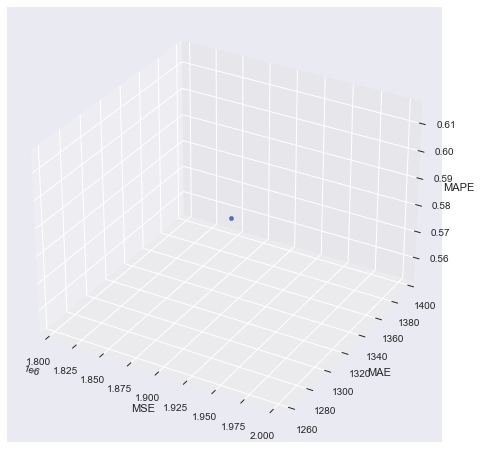

In [18]:
# 计算metrics并绘制散点图：
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error

mse_lis,mae_lis,mape_lis=[],[],[]
for idx,forecast in enumerate(forecast_lis):#forecast: (number of sample paths,prediction length))
    forecast_mean=np.mean(forecast,axis=0)
    gold=test_ds[idx]['target'][-prediction_length:]

    mse_lis.append(mean_squared_error(gold,forecast_mean))
    mae_lis.append(mean_absolute_error(gold,forecast_mean))
    mape_lis.append(mean_absolute_percentage_error(gold,forecast_mean))

fig=plt.figure(figsize=(10,8))
axes=plt.axes(projection='3d')
axes.scatter3D(mse_lis,mae_lis,mape_lis)
axes.set_xlabel('MSE')
axes.set_ylabel('MAE')
axes.set_zlabel('MAPE')

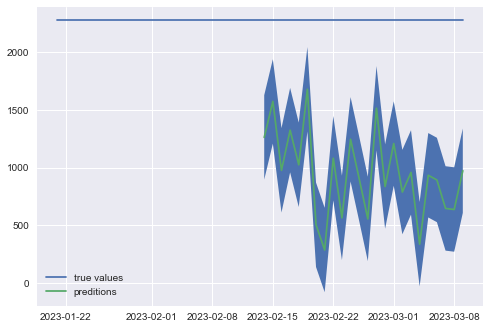

In [19]:
def plot(ts_index):
    fig,axes=plt.subplots()

    index=pd.period_range(
        start=test_ds[ts_index]['start'],
        periods=len(test_ds[ts_index]['target'],),
        freq=freq,
    ).to_timestamp()

    # true values
    axes.plot(index[-2*prediction_length:],test_ds[ts_index]['target'][-2*prediction_length:],label='true values')

    # preditions
    axes.plot(index[-prediction_length:],forecast_mean[-prediction_length:],label='preditions')

    # shadow area
    axes.fill_between(
        index[-prediction_length:],
        y1=forecast_mean-forecast_mean.std(),
        y2=forecast_mean+forecast_mean.std(),
    )

    plt.legend()
    plt.show

plot(0)